In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model, Input
from tensorflow.keras.applications import vgg16
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
VGG16_FROZEN_EPOCHS = 70
FINE_TUNNING_EPOCHS = 70
BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
VALIDATION_SPLIT = 0.2
SEED = 0
N_HIDDEN = 512
DROPOUT_RATE = 0.4
DATA_DIR = Path('../data')

### CHARIZARD DATASET:

In [106]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="validation",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 1176 files belonging to 2 classes.
Using 941 files for training.
Found 1176 files belonging to 2 classes.
Using 235 files for validation.
['charizard', 'non_charizard']


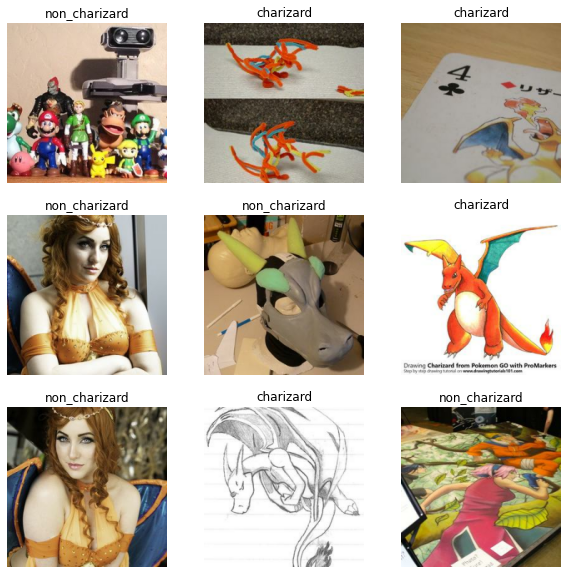

In [111]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels.numpy()[i])])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### CATS VS DOGS DATASET:

In [59]:
#train_ds, info = tfds.load('cats_vs_dogs', with_info=True, shuffle_files=True, as_supervised=True)
train_ds, info = tfds.load('cats_vs_dogs', with_info=True, shuffle_files=True, as_supervised=True, split='train[0%:70%]')
test_ds, _ = tfds.load('cats_vs_dogs', with_info=True, shuffle_files=True, as_supervised=True, split='train[70%:85%]')
val_ds, _ = tfds.load('cats_vs_dogs', with_info=True, shuffle_files=True, as_supervised=True, split='train[85%:100%]')
num_examples = info.splits['train'].num_examples
class_names = ['cat', 'dog']
print(class_names)

def preprocess(image, label):
    image = tf.image.resize(image, [224,224])
    return image, tf.cast(label, tf.float32)

def optmize_dataset(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(num_examples)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = optmize_dataset(train_ds)
test_ds = optmize_dataset(test_ds)
val_ds = optmize_dataset(val_ds)

['cat', 'dog']


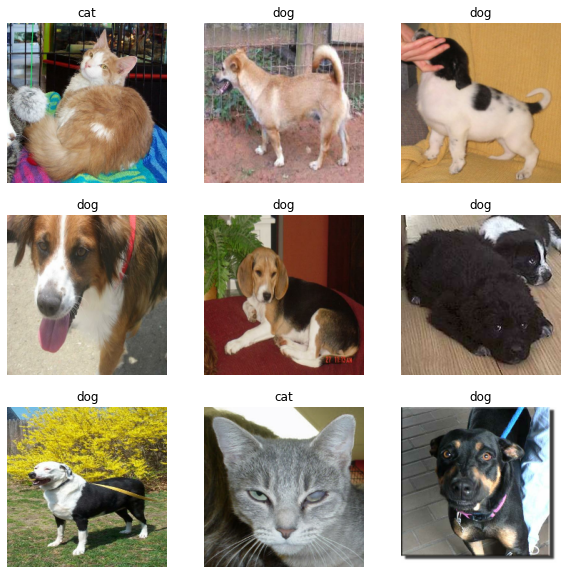

In [65]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels.numpy()[i])])
        plt.axis("off")

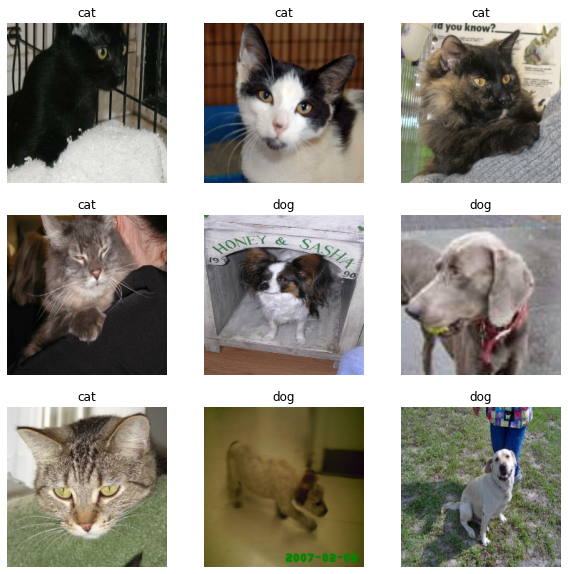

In [66]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels.numpy()[i])])
        plt.axis("off")

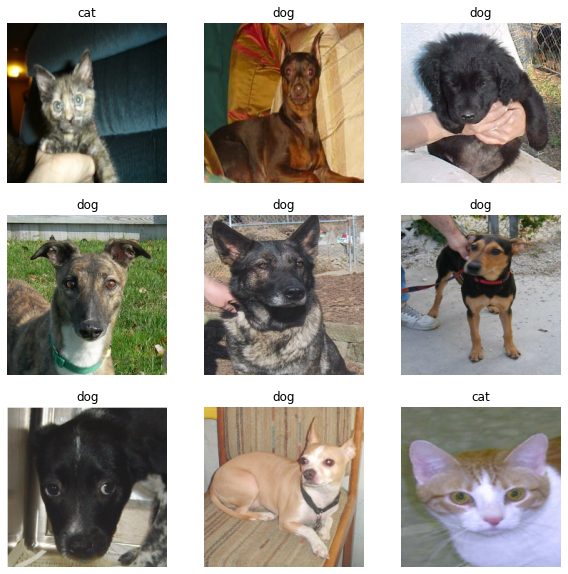

In [67]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels.numpy()[i])])
        plt.axis("off")

In [68]:
def construct_model(random_rot=0.2, random_zoom=0.2):
    
    data_augmentation = Sequential(
      [
        layers.RandomFlip("horizontal", input_shape=(None, None,3)),
        layers.RandomRotation(random_rot),
        layers.RandomZoom(random_zoom),
      ]
    , name='data_augmentation')

    vgg16_model = vgg16.VGG16(include_top=False)

    inputs = Input([IMG_HEIGHT, IMG_WIDTH, 3], dtype = tf.uint8, name='model_inputs')
    x = data_augmentation(inputs)
    x = vgg16.preprocess_input(x)
    x = vgg16_model(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(N_HIDDEN, activation='relu', name='dense_1')(x)
    x = layers.Dropout(DROPOUT_RATE, name='dropout_1')(x)
    x = layers.Dense(N_HIDDEN, activation='relu', name='dense_2')(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(1, activation='sigmoid', name='output')(x)
    model = Model(inputs=inputs, outputs=output, name='final_model')

    return model

def freeze_all_vgg16(model):
    for layer in model.layers:
        if layer.name == 'vgg16':
            for vgg16_layer in layer.layers:
                    vgg16_layer.trainable = False

def unfreeze_last_vgg16(model, which_freeze=15):
    for layer in model.layers:
        if layer.name == 'vgg16':
            for vgg16_layer in layer.layers[:which_freeze]:
                    vgg16_layer.trainable = False
            for vgg16_layer in layer.layers[which_freeze:]:
                    vgg16_layer.trainable = True

def unfreeze_all_vgg16(model):
    for layer in model.layers:
        if layer.name == 'vgg16':
            for vgg16_layer in layer.layers:
                    vgg16_layer.trainable = True

def print_vgg16_trainable(model):
    for layer in model.layers:
        if layer.name == 'vgg16':
            for i, vgg16_layer in enumerate(layer.layers):
                    print(i, vgg16_layer.name, vgg16_layer.trainable)

In [69]:
model = construct_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             

In [70]:
freeze_all_vgg16(model)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=VGG16_FROZEN_EPOCHS,
    callbacks=callbacks,
)

Epoch 1/70
1018/1018 [==============================] - 450s 427ms/step - loss: 0.7145 - accuracy: 0.5522 - val_loss: 0.6457 - val_accuracy: 0.6045 - lr: 0.0010
Epoch 2/70
1018/1018 [==============================] - 426s 419ms/step - loss: 0.6385 - accuracy: 0.6361 - val_loss: 0.6105 - val_accuracy: 0.6864 - lr: 0.0010
Epoch 3/70
1018/1018 [==============================] - 426s 418ms/step - loss: 0.6098 - accuracy: 0.6705 - val_loss: 0.5791 - val_accuracy: 0.6859 - lr: 0.0010
Epoch 4/70
1018/1018 [==============================] - 426s 418ms/step - loss: 0.5768 - accuracy: 0.7000 - val_loss: 0.5822 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 5/70
1018/1018 [==============================] - 425s 417ms/step - loss: 0.5469 - accuracy: 0.7262 - val_loss: 0.5320 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 6/70
1018/1018 [==============================] - 425s 417ms/step - loss: 0.5169 - accuracy: 0.7535 - val_loss: 1.1195 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 7/70
1018/1018 [============

Epoch 46/70
1018/1018 [==============================] - 422s 415ms/step - loss: 0.1648 - accuracy: 0.9364 - val_loss: 0.1537 - val_accuracy: 0.9392 - lr: 1.0000e-08
Epoch 47/70
1018/1018 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9376
Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
1018/1018 [==============================] - 422s 415ms/step - loss: 0.1604 - accuracy: 0.9376 - val_loss: 0.1539 - val_accuracy: 0.9387 - lr: 1.0000e-08
Epoch 48/70
1018/1018 [==============================] - 422s 415ms/step - loss: 0.1649 - accuracy: 0.9385 - val_loss: 0.1527 - val_accuracy: 0.9427 - lr: 1.0000e-09
Epoch 49/70
1018/1018 [==============================] - 423s 415ms/step - loss: 0.1718 - accuracy: 0.9358 - val_loss: 0.1526 - val_accuracy: 0.9424 - lr: 1.0000e-09
Epoch 50/70
1018/1018 [==============================] - 423s 415ms/step - loss: 0.1626 - accuracy: 0.9371 - val_loss: 0.1530 - val_accuracy: 0.9424 - lr: 1.0000e-09
Epo

In [71]:
unfreeze_last_vgg16(model)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNNING_EPOCHS,
    callbacks=callbacks,
)

Epoch 1/70
1018/1018 [==============================] - 423s 415ms/step - loss: 0.1676 - accuracy: 0.9340 - val_loss: 0.1529 - val_accuracy: 0.9427 - lr: 1.0000e-10
Epoch 2/70
1018/1018 [==============================] - 423s 415ms/step - loss: 0.1665 - accuracy: 0.9395 - val_loss: 0.1528 - val_accuracy: 0.9404 - lr: 1.0000e-10
Epoch 3/70
1018/1018 [==============================] - 423s 415ms/step - loss: 0.1626 - accuracy: 0.9377 - val_loss: 0.1530 - val_accuracy: 0.9418 - lr: 1.0000e-10
Epoch 4/70
1018/1018 [==============================] - 423s 415ms/step - loss: 0.1674 - accuracy: 0.9359 - val_loss: 0.1527 - val_accuracy: 0.9424 - lr: 1.0000e-10
Epoch 5/70
1018/1018 [==============================] - 423s 416ms/step - loss: 0.1686 - accuracy: 0.9364 - val_loss: 0.1537 - val_accuracy: 0.9404 - lr: 1.0000e-10
Epoch 6/70
1018/1018 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9356
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-1

In [85]:
model.optimizer.learning_rate = 1e-4

In [87]:
unfreeze_last_vgg16(model)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNNING_EPOCHS,
    callbacks=callbacks,
)

Epoch 1/70
1018/1018 [==============================] - 423s 415ms/step - loss: 0.1760 - accuracy: 0.9326 - val_loss: 0.1560 - val_accuracy: 0.9372 - lr: 1.0000e-04
Epoch 2/70
1018/1018 [==============================] - 423s 416ms/step - loss: 0.1746 - accuracy: 0.9328 - val_loss: 0.1485 - val_accuracy: 0.9424 - lr: 1.0000e-04
Epoch 3/70
1018/1018 [==============================] - 423s 416ms/step - loss: 0.1657 - accuracy: 0.9364 - val_loss: 0.1511 - val_accuracy: 0.9427 - lr: 1.0000e-04
Epoch 4/70
1018/1018 [==============================] - 424s 416ms/step - loss: 0.1751 - accuracy: 0.9310 - val_loss: 0.1523 - val_accuracy: 0.9378 - lr: 1.0000e-04
Epoch 5/70
1018/1018 [==============================] - 424s 416ms/step - loss: 0.1685 - accuracy: 0.9358 - val_loss: 0.1537 - val_accuracy: 0.9427 - lr: 1.0000e-04
Epoch 6/70
1018/1018 [==============================] - 424s 416ms/step - loss: 0.1703 - accuracy: 0.9331 - val_loss: 0.1439 - val_accuracy: 0.9473 - lr: 1.0000e-04
Epoch 7/70

KeyboardInterrupt: 

In [72]:
model.evaluate(test_ds)

219/219 [==============================] - 30s 135ms/step - loss: 0.1529 - accuracy: 0.9384


[0.15290871262550354, 0.9383954405784607]

In [ ]:
model.evaluate(test_ds)